In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [79]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [80]:
df = pd.read_csv("./sample-mcd.csv", encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


# Normalization

In [81]:
# df_prc = df[['reviewer_id', 'review']].copy()

# # Remove non-ASCII
# df_prc['token_sentence'] = df_prc['review'].apply(norm.remove_non_ascii)

# # Expand contractions
# df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.expand_contractions)

# # Remove characters
# df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.remove_characters, args=(True,))

# # Remove enter tab
# df_prc['token_clean'] = df_prc['token_sentence'].apply(norm.remove_enter_tab)

# # Lemmatization
# df_prc['token_clean'] = df_prc['token_clean'].apply(norm.lemmatize_text)

In [82]:
# Tokenization into sentence

df_st = df[['reviewer_id', 'review']].copy()

# Remove non-ASCII
df_st['token_sentence'] = df_st['review'].apply(norm.remove_non_ascii)

# Sentence Tokenization
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect (Rules Based)

In [83]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [00:24<00:00, 21.88it/s]


In [84]:
df_st.head()

,reviewer_id,review,token_sentence,token_clean,sub_aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,{someone spit}
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,{normal transaction}
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,{everyone}
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{}
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,{clear substance}


In [85]:
# Create summary
mask = df_st['sub_aspect'].apply(lambda x: False if len(x) == 0 else True).values

df_summary = df_st[mask].groupby(['reviewer_id'])['token_sentence']\
                .apply(lambda x: '. '.join(x))\
                .reset_index()\
                .rename(columns={'token_sentence': 'summary'})

df_prc = df_st.groupby(['reviewer_id'])\
                .agg({'sub_aspect': lambda x: set().union(*x),
                      'token_clean': lambda x: '. '.join(x),
                     })\
                .reset_index()

df_prc = df_prc.merge(df_summary, on='reviewer_id', how='left').fillna("")
print(df_prc.info())
df_prc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   sub_aspect   100 non-null    object
 2   token_clean  100 non-null    object
 3   summary      100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,reviewer_id,sub_aspect,token_clean,summary
0,1,"{normal transaction, someone spit, everyone, c...",why do it look like someone spit on my food. i...,Why does it look like someone spit on my food....
1,2,"{food place, pleasant experience, food, fast f...",it would mcdonalds .. it be what it be as far ...,It is what it is as far as the food and atmosp...
2,3,"{line, money, refund, manager, mobile order, n...",make a mobile order get to the speaker and che...,Made a mobile order got to the speaker and che...
3,4,"{crispy chicken, chicken sandwich, customer se...",my mc .. crispy chicken sandwich be customer s...,Crispy chicken sandwich was customer service ...
4,5,"{english, order, large meal, large fry, double...",i repeat my order 3 time in the drive thru. an...,I repeat my order 3 times in the drive thru. i...


In [86]:
# # Get aspect from rules
# tqdm.pandas()
# df_prc['sub_aspect'] = df_prc['token_clean']\
#                         .progress_apply(util.get_aspect_rules)

In [87]:
# print(df_prc.info())
# df_prc.head()

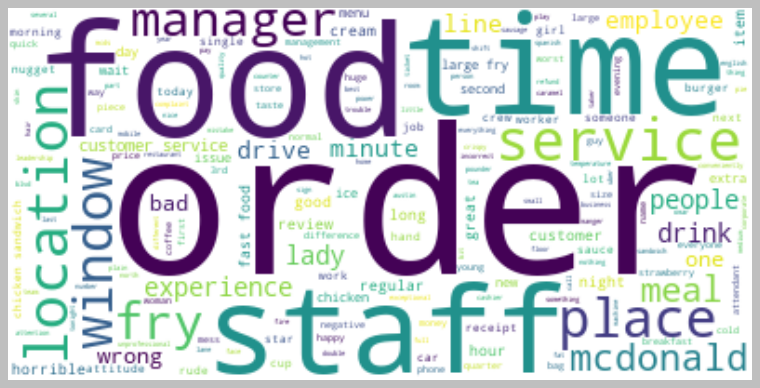

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_prc['sub_aspect'].values
for i in range(df_prc.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [89]:
# df['sub_aspect'] = df_prc['sub_aspect'].apply(lambda x: ", ".join(list(x)))

# Get Topic

In [90]:
def get_optimum_lda(dictionary, corpus, texts, limit,
                    start=2, step=1, get_result=False,
                    iterations=20, passes=1):
    coherence_values = []
    
    for n in range(start, limit, step):
        lda = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=n,
                                         id2word=dictionary,
                                         iterations=iterations,
                                         passes=passes)
        
        # Create coherence
        coherence_model = CoherenceModel(model=lda, 
                                         texts=texts,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    
    opt_num_topics = start + coherence_values.index(max(coherence_values))
    
    lda_opt = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=opt_num_topics,
                                         id2word=dictionary)
    
    if get_result:
        print(coherence_values)
    
    return lda_opt



In [91]:
import gensim
from gensim.models import CoherenceModel


texts = df_prc['token_clean'].apply(util.preprocess_lda)

dictionary = gensim.corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

lda_opt = get_optimum_lda(dictionary, bow_corpus,
                          texts, 10, get_result=True,
                          passes=50, iterations=100)

[0.5094352004632003, 0.5094352004632003, 0.5094352004632003, 0.5094352004632003, 0.5094352004632002, 0.5094352004632005, 0.5094352004632003, 0.5094352004632003]


In [92]:
# Print topic
for idx, topic in lda_opt.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.480*"order" + 0.143*"time" + 0.114*"service" + 0.086*"food" + 0.086*"staff" + 0.058*"drive" + 0.030*"thru" + 0.002*"location"
Topic: 1 
Words: 0.242*"time" + 0.241*"food" + 0.166*"order" + 0.161*"service" + 0.086*"drive" + 0.082*"location" + 0.011*"staff" + 0.011*"thru"
Topic: 2 
Words: 0.351*"order" + 0.235*"time" + 0.165*"drive" + 0.096*"location" + 0.050*"staff" + 0.050*"thru" + 0.027*"food" + 0.027*"service"
Topic: 3 
Words: 0.402*"food" + 0.278*"order" + 0.153*"staff" + 0.103*"location" + 0.053*"service" + 0.004*"time" + 0.004*"drive" + 0.004*"thru"
Topic: 4 
Words: 0.213*"drive" + 0.195*"thru" + 0.160*"order" + 0.144*"location" + 0.107*"food" + 0.106*"time" + 0.055*"staff" + 0.020*"service"
Topic: 5 
Words: 0.619*"order" + 0.121*"location" + 0.092*"service" + 0.063*"time" + 0.034*"food" + 0.034*"drive" + 0.034*"thru" + 0.004*"staff"
Topic: 6 
Words: 0.222*"drive" + 0.198*"time" + 0.174*"food" + 0.150*"order" + 0.125*"service" + 0.052*"staff" + 0.052*"thru" + 0.

In [93]:
def predict_topic(text):
    text = util.preprocess_lda(text)
    bow_vector = dictionary.doc2bow(text)
    
    result = sorted(lda_opt[bow_vector], 
                    key=lambda x: -1*x[1])[0][0]
    
    return result
    
# Extract keywords into a dictionary or list
threshold = 0.1
topics_dict = {}
for topic_num, topic in lda_opt.show_topics(num_topics=10,
                                                num_words=10,
                                                formatted=False):
    keywords = [word for word, w in topic if w > threshold]
    topics_dict[topic_num] = keywords

In [94]:
topics_dict

{0: ['order', 'time', 'service'],
 1: ['time', 'food', 'order', 'service'],
 2: ['order', 'time', 'drive'],
 3: ['food', 'order', 'staff', 'location'],
 4: ['drive', 'thru', 'order', 'location', 'food', 'time'],
 5: ['order', 'location'],
 6: ['drive', 'time', 'food', 'order', 'service']}

In [95]:
df = df.merge(df_prc[['reviewer_id', 'summary', 'sub_aspect']], on='reviewer_id', how='left', )

In [96]:
tqdm.pandas()
df['topic'] = df_prc['token_clean'].progress_apply(predict_topic)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 388.15it/s]


In [97]:
tqdm.pandas()
df['key_topic'] = df['topic']\
                    .progress_apply(lambda x: ", ".join(topics_dict[x]))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [98]:
tqdm.pandas()
df['sub_aspect'] = df['sub_aspect']\
                    .progress_apply(lambda x: ", ".join(list(x)))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 98135.33it/s]


In [99]:
df.head()

,reviewer_id,review_time,review,rating,summary,sub_aspect,topic,key_topic
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,Why does it look like someone spit on my food....,"normal transaction, someone spit, everyone, cl...",3,"food, order, staff, location"
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,It is what it is as far as the food and atmosp...,"food place, pleasant experience, food, fast fo...",3,"food, order, staff, location"
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,Made a mobile order got to the speaker and che...,"line, money, refund, manager, mobile order, ne...",5,"order, location"
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars,Crispy chicken sandwich was customer service ...,"crispy chicken, chicken sandwich, customer ser...",1,"time, food, order, service"
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,I repeat my order 3 times in the drive thru. i...,"english, order, large meal, large fry, double ...",4,"drive, thru, order, location, food, time"


In [100]:
df.to_csv('result_mcd.csv', index=False)